# Comparison between Exp and Pow forgetting curves

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/main/archive/research/forgetting_curve.ipynb)

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "../collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpgk filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"

# Set it to True if you don't want the optimizer to use the review logs from suspended cards.
filter_out_suspended_cards = False

In [2]:
import zipfile
import sqlite3
import time
import pandas as pd
import numpy as np
import os
from datetime import timedelta, datetime
from sklearn.metrics import mean_squared_error
from itertools import accumulate
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
tqdm.pandas()

In [3]:
"""Step 1"""
# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Deck file extracted successfully!")

"""Step 2"""
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute(f"""
SELECT *
FROM revlog
WHERE cid IN (
    SELECT id
    FROM cards
    {"WHERE queue != -1" if filter_out_suspended_cards else ""}
)
"""
)
revlog = res.fetchall()
if len(revlog) == 0:
    raise Exception("No review log found!")
df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'r', 'ivl', 'last_lvl', 'factor', 'time', 'type']
df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000)].copy()

df_set_due_date = df[(df['type'] == 4) & (df['ivl'] > 0)]
df.drop(df_set_due_date.index, inplace=True)

df['create_date'] = pd.to_datetime(df['cid'] // 1000, unit='s')
df['create_date'] = df['create_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df['review_date'] = pd.to_datetime(df['id'] // 1000, unit='s')
df['review_date'] = df['review_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df.drop(df[df['review_date'].dt.year < 2006].index, inplace=True)
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)

df['is_learn_start'] = (df['type'] == 0) & (df['type'].shift() != 0)
df['sequence_group'] = df['is_learn_start'].cumsum()
last_learn_start = df[df['is_learn_start']].groupby('cid')['sequence_group'].last()
df['last_learn_start'] = df['cid'].map(last_learn_start).fillna(0).astype(int)
df['mask'] = df['last_learn_start'] <= df['sequence_group']
df = df[df['mask'] == True].copy()
df.drop(columns=['is_learn_start', 'sequence_group', 'last_learn_start', 'mask'], inplace=True)
df = df[(df['type'] != 4)].copy()

type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])
df.to_csv("revlog.csv", index=False)
print("revlog.csv saved.")

df = df[(df['type'] != 3) | (df['factor'] != 0)].copy()
df['real_days'] = df['review_date'] - timedelta(hours=int(next_day_starts_at))
df['real_days'] = pd.DatetimeIndex(df['real_days'].dt.floor('D', ambiguous='infer', nonexistent='shift_forward')).to_julian_date()
df.drop_duplicates(['cid', 'real_days'], keep='first', inplace=True)
df['delta_t'] = df.real_days.diff()
df.dropna(inplace=True)
df['i'] = df.groupby('cid').cumcount() + 1
df.loc[df['i'] == 1, 'delta_t'] = 0
df = df.groupby('cid').filter(lambda group: group['type'].iloc[0] == 0)
df['prev_type'] = df.groupby('cid')['type'].shift(1).fillna(0).astype(int)
df['helper'] = ((df['type'] == 0) & ((df['prev_type'] == 1) | (df['prev_type'] == 2)) & (df['i'] > 1)).astype(int)
df['helper'] = df.groupby('cid')['helper'].cumsum()
df = df[df['helper'] == 0]
del df['prev_type']
del df['helper']

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('cid', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('cid', group_keys=False)['r'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]
df = df.groupby('cid').filter(lambda group: group['id'].min() > time.mktime(datetime.strptime(revlog_start_date, "%Y-%m-%d").timetuple()) * 1000)
df['y'] = df['r'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
df.to_csv('revlog_history.tsv', sep="\t", index=False)

Deck file extracted successfully!
revlog.csv saved.


In [4]:
from scipy.optimize import curve_fit

df_analysis = df[(df['i'] > 1) & (df['delta_t'] > 0) & (df['t_history'].str.count(',0') == 0)].copy()


df_analysis['retention'] = df_analysis.groupby(by=['r_history', 't_history', 'delta_t'], group_keys=False)['y'].transform('mean')
df_analysis['total_cnt'] = df_analysis.groupby(by=['r_history', 't_history', 'delta_t'], group_keys=False)['id'].transform('count')
df_analysis.drop(columns=['id', 'cid', 'usn', 'r', 'ivl', 'last_lvl', 'factor', 'time', 'type', 'create_date', 'review_date', 'real_days', 'y'], inplace=True)
df_analysis.drop_duplicates(inplace=True)
df_analysis.sort_values(by=['r_history', 't_history', 'delta_t'], inplace=True)
df_analysis

,delta_t,i,t_history,r_history,retention,total_cnt
275,1.0,2,0,1,0.893817,1488
5111,2.0,2,0,1,0.872222,360
218,3.0,2,0,1,0.790909,110
345,4.0,2,0,1,0.800000,50
396,5.0,2,0,1,0.707317,41
...,...,...,...,...,...,...
38515,43.0,5,"0,1,4,12","4,4,4,4",1.000000,1
7968,139.0,5,"0,4,12,38","4,4,4,4",1.000000,1
38516,122.0,6,"0,1,4,12,43","4,4,4,4,3",1.000000,1
7969,410.0,6,"0,4,12,38,139","4,4,4,4,3",1.000000,1


In [5]:
def exp_curve(delta_t, S):
    return 0.9 ** (delta_t / S)

def reverse_exp_curve(delta_t, R):
    return np.log(0.9) / np.log(R) * delta_t

def pow_curve(delta_t, S):
    return (1 + delta_t / (9 * S)) ** -1

def reverse_pow_curve(delta_t, R):
    return delta_t / 9 / (1 / R - 1)

def fit_stability(delta_t, recall, cnt, curve_func, reverse_curve_func):
    try:
        params, _ = curve_fit(curve_func, delta_t, recall, sigma=1/np.sqrt(cnt), bounds=((0.1), (3650)))
        return params[0]
    except Exception as e:
        print(e)
        return reverse_curve_func(delta_t.values, recall.values)[0]

In [6]:
df_exp_stability = df_analysis.groupby(by=['r_history', 't_history']).progress_apply(lambda group: fit_stability(group['delta_t'], group['retention'], group['total_cnt'], exp_curve, reverse_exp_curve)).reset_index()

  0%|          | 0/50077 [00:00<?, ?it/s]

In [7]:
df_pow_stability = df_analysis.groupby(by=['r_history', 't_history']).progress_apply(lambda group: fit_stability(group['delta_t'], group['retention'], group['total_cnt'], pow_curve, reverse_pow_curve)).reset_index()

  0%|          | 0/50077 [00:00<?, ?it/s]

In [8]:
tmp = pd.merge(df_analysis, df_exp_stability, on=['r_history', 't_history'], how='left').rename(columns={0: 'exp_stability'})
df_test = pd.merge(tmp, df_pow_stability, on=['r_history', 't_history'], how='left').rename(columns={0: 'pow_stability'})

In [9]:
df_test['exp_recall'] = exp_curve(df_test['delta_t'], df_test['exp_stability'])
df_test['pow_recall'] = pow_curve(df_test['delta_t'], df_test['pow_stability'])

In [10]:
df_test['MSE_exp'] = (df_test['exp_recall'] - df_test['retention']) ** 2
df_test['MSE_pow'] = (df_test['pow_recall'] - df_test['retention']) ** 2
df_test['MSE_exp_weighted'] = df_test['MSE_exp'] * df_test['total_cnt']
df_test['MSE_pow_weighted'] = df_test['MSE_pow'] * df_test['total_cnt']
df_test

,delta_t,i,t_history,r_history,retention,total_cnt,exp_stability,pow_stability,exp_recall,pow_recall,MSE_exp,MSE_pow,MSE_exp_weighted,MSE_pow_weighted
0,1.0,2,0,1,0.893817,1488,1.355016,1.251629,0.925190,0.918465,0.000984,0.000608,1.464587,0.903974
1,2.0,2,0,1,0.872222,360,1.355016,1.251629,0.855977,0.849223,0.000264,0.000529,0.095007,0.190421
2,3.0,2,0,1,0.790909,110,1.355016,1.251629,0.791941,0.789690,0.000001,0.000001,0.000117,0.000163
3,4.0,2,0,1,0.800000,50,1.355016,1.251629,0.732697,0.737957,0.004530,0.003849,0.226488,0.192468
4,5.0,2,0,1,0.707317,41,1.355016,1.251629,0.677884,0.692585,0.000866,0.000217,0.035519,0.008898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56878,43.0,5,"0,1,4,12","4,4,4,4",1.000000,1,3635.807087,3635.875351,0.998755,0.998688,0.000002,0.000002,0.000002,0.000002
56879,139.0,5,"0,4,12,38","4,4,4,4",1.000000,1,3649.945982,3649.947746,0.995996,0.995786,0.000016,0.000018,0.000016,0.000018
56880,122.0,6,"0,1,4,12,43","4,4,4,4,3",1.000000,1,3649.945782,3649.947341,0.996485,0.996300,0.000012,0.000014,0.000012,0.000014
56881,410.0,6,"0,4,12,38,139","4,4,4,4,3",1.000000,1,3649.949074,3649.953781,0.988235,0.987673,0.000138,0.000152,0.000138,0.000152


In [11]:
first_review = df_test[df_test['i'] == 2].copy()
exp_rmse = np.sqrt(first_review['MSE_exp_weighted'].sum() / first_review['total_cnt'].sum())
pow_rmse = np.sqrt(first_review['MSE_pow_weighted'].sum() / first_review['total_cnt'].sum())
print(f"first review exp_rmse: {exp_rmse}")
print(f"first review pow_rmse: {pow_rmse}")

first review exp_rmse: 0.027728287577305333
first review pow_rmse: 0.025822027313503877


In [12]:
rest_reviews = df_test[df_test['i'] > 2].copy()
exp_rmse = np.sqrt(rest_reviews['MSE_exp_weighted'].sum() / rest_reviews['total_cnt'].sum())
pow_rmse = np.sqrt(rest_reviews['MSE_pow_weighted'].sum() / rest_reviews['total_cnt'].sum())
print(f"rest reviews exp_rmse: {exp_rmse}")
print(f"rest reviews pow_rmse: {pow_rmse}")

rest reviews exp_rmse: 0.08928613755836967
rest reviews pow_rmse: 0.09506514574203066


In [13]:
def exp_rmse(df):
    return np.sqrt(df['MSE_exp_weighted'].sum() / df['total_cnt'].sum())

def pow_rmse(df):
    return np.sqrt(df['MSE_pow_weighted'].sum() / df['total_cnt'].sum())

# compare exp and pow in each group
comparison = df_test.groupby('i').apply(lambda group: pd.Series({'exp_rmse': exp_rmse(group), 'pow_rmse': pow_rmse(group), 'cnt': group['total_cnt'].sum()}))
comparison

,exp_rmse,pow_rmse,cnt
i,,,
2,0.027728,0.025822,9761.0
3,0.068440,0.068797,9683.0
4,0.123281,0.123780,9622.0
5,0.154008,0.155173,9176.0
6,0.138374,0.141275,7786.0
...,...,...,...
62,0.001551,0.001634,3.0
63,0.001012,0.001066,2.0
64,0.000308,0.000325,1.0


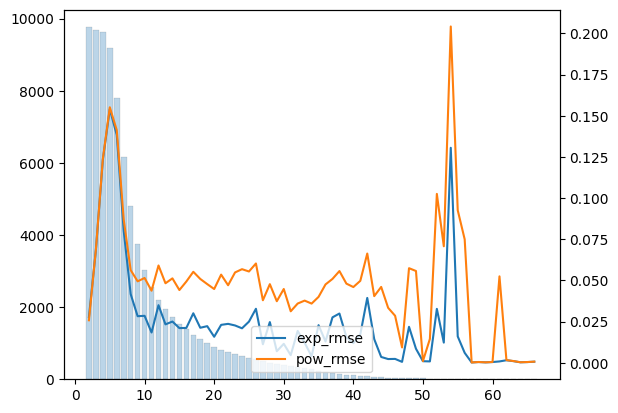

In [14]:
from matplotlib import pyplot as plt
# plot exp_rmse and pow_rmse in each group and show the cnt

plt.bar(comparison.index, comparison['cnt'], label='cnt', ec='k', lw=.2, alpha=0.3)
plt.twinx()
plt.plot(comparison.index, comparison['exp_rmse'], label='exp_rmse')
plt.plot(comparison.index, comparison['pow_rmse'], label='pow_rmse')
plt.legend(loc='lower center')
plt.show()